# Week 7: Differential abundance analysis

In this notebook, we will explore how to test whether specific ASVs (amplicon sequence variants) or taxa show differences in abundance between groups of samples—a type of analysis known as _differential abundance_.

Analyzing microbiome data presents two key challenges:
- Sparsity: The data contains many zero-values.
- Compositionality: The values are relative and sum to 1.

These challenges make traditional statistical methods (such as ANOVA or t-tests) unsuitable for differential abundance testing. Instead, we can use ANCOM-BC (Analysis of Composition of Microbiomes with Bias Correction), a compositionally aware method designed to identify differentially abundant features.

**Exercise overview:**

[0. Setup](#setup)<br>
[1. Data exploration](#data-exploration)<br>
[2. ANCOM](#ancom)<br>
[3. Checkpoint](#checkpoint)

<a id='setup'></a>

## 1. Setup

The cell below will import all the packages required in the downstream analyses as well as set all the necessary variables and data paths.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import seaborn as sns
from scipy.stats import shapiro, kruskal, f_oneway
import subprocess

%matplotlib inline

In [2]:
# assigning variables throughout the notebook

# location of this week's data and all the results produced by this notebook
# - this should be a path relative to your working directory
raw_data_dir = "../data/raw"
data_dir = "../data/processed"
vis_dir  = "../results"

In [3]:
sns.set_style("white")
sns.set_theme(style="ticks", palette="pastel")

<a id='data-exploration'></a>
## 1. Data exploration

Microbiome data poses challenges for traditional statistical methods due to its sparsity (many zero-values) and non-normal distribution. To better understand these limitations, we'll visualize the data using a violin plot—a blend of a histogram and a box plot—that shows the full distribution along with summary statistics.

In [4]:
data = q2.Artifact.load(f'{data_dir}/table.qza').view(pd.DataFrame)

We show that the features are not normally distributed!

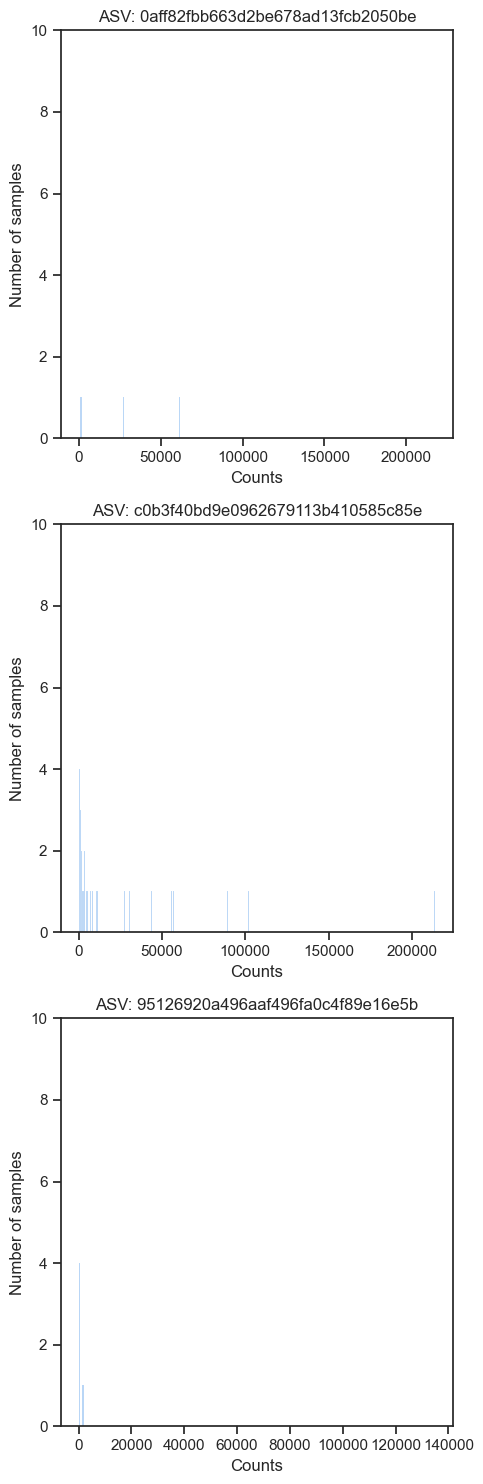

In [5]:
# Get the top three most abundant sequence variants
# based on sum of observed sequence counts. Create a dataframe of ASV counts 
# with samples as rows and sequence variants as columns.
top_three = data[data.sum(axis=0).sort_values(ascending=False).head(n=3).index]

top_three
# Your turn to try! Now view each of them as a histogram, as number of samples per ASV.
fig, axes = plt.subplots(3, 1, figsize=(5, 15))

for i, asv in enumerate(top_three):
    ax = axes.flatten()[i]
    sns.histplot(top_three, x=top_three[asv], ax=ax)
    ax.set_xlabel("Counts")
    ax.set_ylabel("Number of samples")
    ax.set_title(f"ASV: {asv}")
    ax.set_ylim(0,10)
    
    
    
plt.tight_layout()
plt.show()


To create a violin plot, we need to restructure the data into a new DataFrame with three columns: sample name, ASV ID, and ASV abundance. To simplify the visualization, we'll use only 15 samples from the original dataset.

In [6]:
n = 15

# draw n ASVs out of the original DataFrame
data_samp = data.sample(n=n, axis=1, random_state=23)

# create a new DataFrame with three columns (sample, ASV, abundance)
col_names = {'level_0': 'sample', 'level_1': 'asv', 0: 'count'}
data_plot = data_samp.stack().reset_index().rename(columns=col_names)

# make sure the shape is correct (no. of rows should be equal to the size of our random 
# sample multiplied by number of samples)
assert data_plot.shape[0] == n * data_samp.shape[0], 'The new DataFrame has an incorrect no. of rows.'

In [7]:
data_plot.head()

sample                               asv  count
0  EG0024  ead3a6d4c6481164ab627c229bab6f21    0.0
1  EG0024  81fe043da496de58da2066d994d5f979    0.0
2  EG0024  caf3dff992adc7810805466d1f5d21d9    0.0
3  EG0024  8fa5c543f4365d27e41836b099af98bf    0.0
4  EG0024  7e4730fdfcd01a668dca80d4168c1029    0.0

Now, let's plot distributions of our ASVs using seaborn's violin plot:

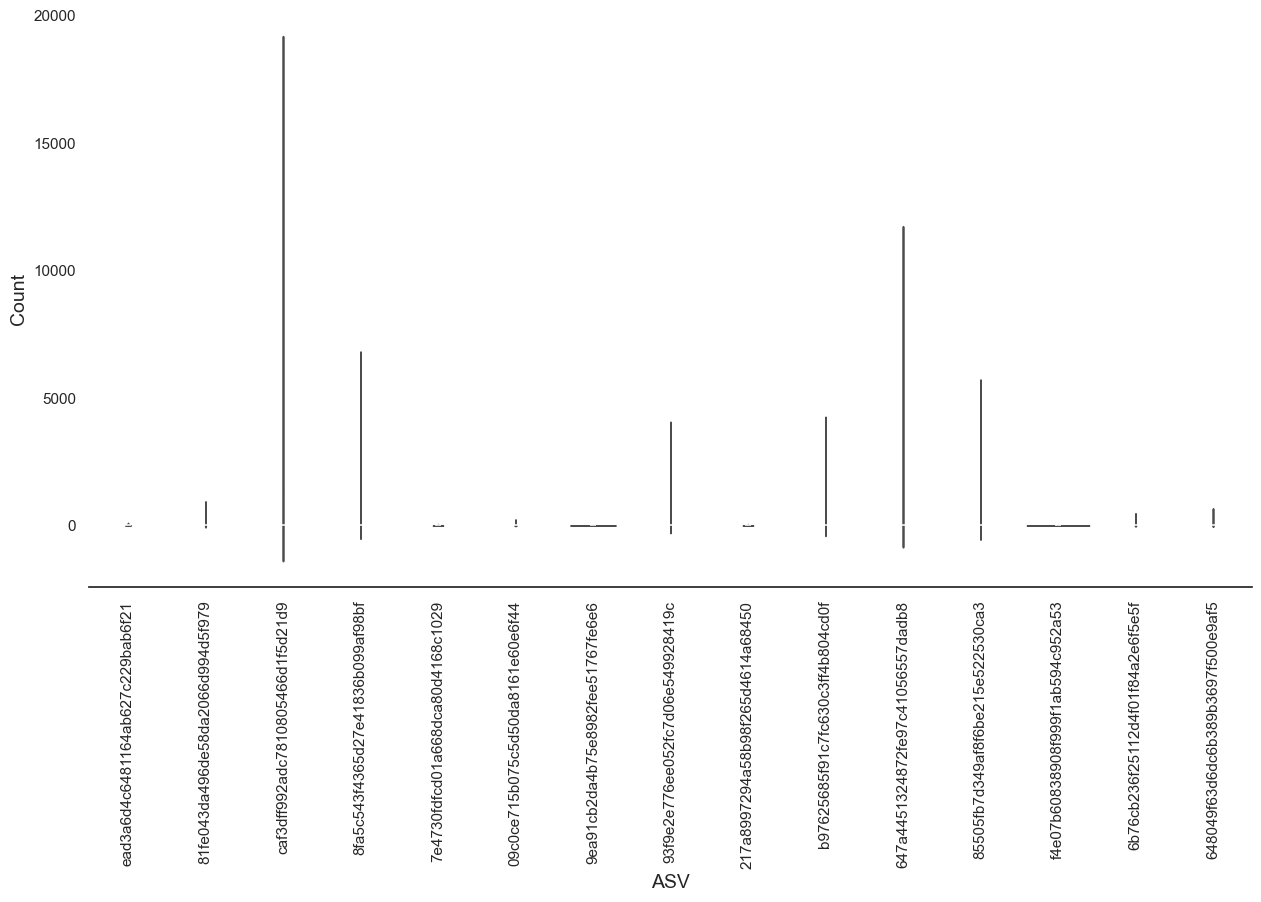

In [8]:
with sns.axes_style('white'), sns.color_palette('Set1'):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 7.5)
    
    sns.violinplot(data=data_plot, x='asv', y='count', ax=ax)
    sns.despine(left=True)
    
    # adjust tick labels and axes titles
    ax.tick_params(axis='x', rotation=90, labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.set_xlabel('ASV', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

The plot shows most values clustering around 0, with only a few differing. To quantify this pattern across all ASVs, we can test for data normality using Shapiro-Wilk test.

In [9]:
alpha = 0.05
results = {}

# iterate through rows (samples) and test each of them for normality
for asv_name, asv_values in data.items():
    stat, p = shapiro(asv_values)
    results[asv_name] = p

# convert test results into a DataFrame
results_df = pd.DataFrame(data=results.values(), index=results.keys(), columns=['p'])

# add a new column with a descriptive test result
results_df['is_normal'] = results_df['p'] > alpha

Visualize:

In [10]:
results_df

p  is_normal
65c81b7f020fa6530e5995cfadbed4b8  2.074308e-22      False
3b5167fc05d221e402cb1748506b8442  2.074308e-22      False
8b03f72e05e140685a739928d4dd2619  2.074308e-22      False
dc5e130892eb358854eb477a790f8af9  2.074308e-22      False
9b4ec0ce1b21a5a1172c2f0452d9f241  2.074308e-22      False
...                                        ...        ...
049818b152db3312886899302aa53e00  2.074308e-22      False
0804cc0c3a3cb43a50c6272ab93f6e67  2.074308e-22      False
7553d3ce1a630921aa4ec5bc5298421a  2.074308e-22      False
c04bf7fb221724977d918399c366696f  2.074308e-22      False
feee01d5719e184949ec06c2034a0c30  2.074308e-22      False

[2001 rows x 2 columns]

To identify ASVs with a normal distribution, sum the values in the is_normal column. Since True equals 1 and False equals 0, a sum greater than 0 indicates the presence of normally distributed ASVs.

In [11]:
print('Number of ASVs with normal distribution:', results_df['is_normal'].sum())

Number of ASVs with normal distribution: 0


None is normally distributed! So we cannot use the common parametric tests.

In [12]:
meta = pd.read_csv(f"{raw_data_dir}/metadata.tsv", sep="\t")
meta.head()

Sample_Name Patient_ID Stool_Consistency Patient_Sex  Sample_Day  \
0      EG2580       P042            liquid           F          13   
1      EG2559       P043            liquid           M          15   
2      EG2537       P042            liquid           F           0   
3      EG2518       P043            liquid           M           0   
4      EG2490       P030            formed           F           0   

   Recovery_Day  Cohort_Number  
0          17.0              2  
1          17.0              2  
2          17.0              1  
3          17.0              1  
4           NaN              1

<a id='ancom'></a>
## 2. ANCOM

To address the dataset's limitations, we’ll start by filtering the feature table. Only features with a minimum frequency of 25 and presence in at least 5 samples will be retained. This helps improve resolution and minimizes the false discovery rate (FDR) penalty for features below the noise threshold. `filter-features` action from the `feature-table` plugin is used and applied to the `FeatureTable` from `01_data_download_and_preprocessing.ipynb`.

In [13]:
! qiime feature-table filter-features \
    --i-table $data_dir/table.qza \
    --p-min-frequency 25 \
    --p-min-samples 5 \
    --o-filtered-table $data_dir/table_abund.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund.qza


Collapse the results to the species level:

In [14]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 7 \
    --o-collapsed-table $data_dir/table_abund_l7.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l7.qza


Collapse the results to the genus level:

In [15]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 6 \
    --o-collapsed-table $data_dir/table_abund_l6.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l6.qza


Collapse the results to the family level:

In [16]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 5 \
    --o-collapsed-table $data_dir/table_abund_l5.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l5.qza


Collapse the results to the order level:

In [17]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 4 \
    --o-collapsed-table $data_dir/table_abund_l4.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l4.qza


Collapse the results to the class level:

In [18]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 3 \
    --o-collapsed-table $data_dir/table_abund_l3.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l3.qza


Collapse the results to the phylum level:

In [19]:
! qiime taxa collapse \
    --i-table $data_dir/table_abund.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-level 2 \
    --o-collapsed-table $data_dir/table_abund_l2.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_abund_l2.qza


### Stool Consistency

We will try to first find taxa differentially abundant in the different stool consistencies:  *liquid*, *formed* and *semi-formed*. 

In [20]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Stool_Consistency \
    --o-differentials $data_dir/ancombc_stool_consistency_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/ancombc_stool_consistency_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/ancombc_stool_consistency_results.qzv

Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_stool_consistency_differentials.qza
Saved Visualization to: ../data/processed/ancombc_stool_consistency_da_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_stool_consistency_results.qzv


The results are visualized in the following cell. The barplot `ancombc_stool_consistency_da_barplot.qzv` displayed which features are enriched or depleted in each group. We are comparing *liquid*, *formed* and *semi-formed*, and *liquid* and  *semi-formed* are used as the comparison group and the *formed*  as the reference group. So the features that are more abundant in the *formed* are shown as enriched (blue bars), and features that are more abundant in gut samples are shown as depleted (orange bars). 

In [21]:
! qiime tools view $data_dir/ancombc_stool_consistency_da_barplot.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [ ]:
! qiime tools view $data_dir/ancombc_stool_consistency_results.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

I will repeat the same thing for all of the taxonomy orders:

In [22]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table_abund_l6.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Stool_Consistency \
    --o-differentials $data_dir/ancombc_stool_consistency_l6_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_stool_consistency_l6_differentials.qza \
    --o-visualization $data_dir/ancombc_stool_consistency_l6_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_stool_consistency_differentials.qza \
    --o-visualization $data_dir/ancombc_stool_consistency_l6_results.qzv
    
    

Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_stool_consistency_l6_differentials.qza
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l6_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l6_results.qzv


In [ ]:
data_dir  

'/path/to/your/data'

In [23]:
# Define the data directory and levels
levels = ["l7", "l6", "l5", "l4", "l3", "l2"]


# Loop through the levels and run the commands
for level in levels:
    try:
        print(f"Running commands for level: {level}")
        
        # Run ANCOM-BC
        subprocess.run([
            "qiime", "composition", "ancombc",
            "--i-table", f"{data_dir}/table_abund_{level}.qza",
            "--m-metadata-file", f"{data_dir}/metadata.tsv",
            "--p-formula", "Stool_Consistency",
            "--o-differentials", f"{data_dir}/ancombc_stool_consistency_{level}_differentials.qza"
        ], check=True)
        
        # Generate a barplot
        subprocess.run([
            "qiime", "composition", "da-barplot",
            "--i-data", f"{data_dir}/ancombc_stool_consistency_{level}_differentials.qza",
            "--o-visualization", f"{data_dir}/ancombc_stool_consistency_{level}_barplot.qzv"
        ], check=True)
        
        # Generate a results table
        subprocess.run([
            "qiime", "composition", "tabulate",
            "--i-data", f"{data_dir}/ancombc_stool_consistency_{level}_differentials.qza",
            "--o-visualization", f"{data_dir}/ancombc_stool_consistency_{level}_results.qzv"
        ], check=True)
        
        print(f"Commands for level {level} completed successfully!")
    except subprocess.CalledProcessError as e:
        print(f"Error running commands for level {level}: {e}")


Running commands for level: l7
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_stool_consistency_l7_differentials.qza
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l7_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l7_results.qzv
Commands for level l7 completed successfully!
Running commands for level: l6
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_stool_consistency_l6_differentials.qza
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l6_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l6_results.qzv
Commands for level l6 completed successfully!
Running commands for level: l5
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_stool_consistency_l5_differentials.qza
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l5_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_stool_consistency_l5

In [ ]:
! qiime tools view $data_dir/ancombc_stool_consistency__l6_barplot.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [ ]:
! qiime tools view $data_dir/ancombc_stool_consistency_l6_results.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

### Sex

In [24]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/table_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Patient_Sex \
    --o-differentials $data_dir/ancombc_sex_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/ancombc_sex_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/ancombc_sex_differentials.qza \
    --o-visualization $data_dir/ancombc_sex_results.qzv

Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_sex_differentials.qza
Saved Visualization to: ../data/processed/ancombc_sex_da_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_sex_results.qzv


In [ ]:
! qiime tools view $data_dir/ancombc_sex_da_barplot.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [ ]:
! qiime tools view $data_dir/ancombc_sex_results.qzv

In [25]:
levels = ["l7", "l6", "l5", "l4", "l3", "l2"]

# Loop through the levels and run the commands
for level in levels:
    try:
        print(f"Running commands for level: {level}")
        
        # Run ANCOM-BC
        subprocess.run([
            "qiime", "composition", "ancombc",
            "--i-table", f"{data_dir}/table_abund_{level}.qza",
            "--m-metadata-file", f"{data_dir}/metadata.tsv",
            "--p-formula", "Patient_Sex",
            "--o-differentials", f"{data_dir}/ancombc_sex_{level}_differentials.qza"
        ], check=True)
        
        # Generate a barplot
        subprocess.run([
            "qiime", "composition", "da-barplot",
            "--i-data", f"{data_dir}/ancombc_sex_{level}_differentials.qza",
            "--o-visualization", f"{data_dir}/ancombc_sex_{level}_barplot.qzv"
        ], check=True)
        
        # Generate a results table
        subprocess.run([
            "qiime", "composition", "tabulate",
            "--i-data", f"{data_dir}/ancombc_sex_{level}_differentials.qza",
            "--o-visualization", f"{data_dir}/ancombc_sex_{level}_results.qzv"
        ], check=True)
        
        print(f"Commands for level {level} completed successfully!")
    except subprocess.CalledProcessError as e:
        print(f"Error running commands for level {level}: {e}")

Running commands for level: l7
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_sex_l7_differentials.qza
Saved Visualization to: ../data/processed/ancombc_sex_l7_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_sex_l7_results.qzv
Commands for level l7 completed successfully!
Running commands for level: l6
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_sex_l6_differentials.qza
Saved Visualization to: ../data/processed/ancombc_sex_l6_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_sex_l6_results.qzv
Commands for level l6 completed successfully!
Running commands for level: l5
Saved FeatureData[DifferentialAbundance] to: ../data/processed/ancombc_sex_l5_differentials.qza
Saved Visualization to: ../data/processed/ancombc_sex_l5_barplot.qzv
Saved Visualization to: ../data/processed/ancombc_sex_l5_results.qzv
Commands for level l5 completed successfully!
Running commands for level: l4
Saved FeatureData[DifferentialAbunda

In [ ]:
! qiime tools view $data_dir/ancombc_sex_l7_barplot.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [ ]:
! qiime tools view $data_dir/ancombc_sex_l7_results.qzv

## Result analysis - finding differentially abundant features

### Stool consistency

In [26]:
from q2_composition import DataLoafPackageDirFmt

dirfmt = q2.Artifact.load(f'{data_dir}/ancombc_stool_consistency_differentials.qza')
# view it as that directory format
dirfmt = dirfmt.view(DataLoafPackageDirFmt)

# this directory format has a model attribute called `data_slices`
# each of which represents a CSV in the directory

slices = {}
for relpath, view in dirfmt.data_slices.iter_views(pd.DataFrame):
    slices[str(relpath)] = view

In [27]:
lfc = list(slices.values())[0]
lfc.set_index(lfc.columns[0], inplace=True)
lfc.columns = ['lfc_' + col for col in lfc.columns]
p_val = list(slices.values())[1]
p_val.set_index(p_val.columns[0], inplace=True)
p_val.columns = ['p_val_' + col for col in p_val.columns]
q_val = list(slices.values())[2]
q_val.set_index(q_val.columns[0], inplace=True)
q_val.columns = ['q_val_' + col for col in q_val.columns]

df = pd.concat([lfc, p_val, q_val], axis=1, join='inner')

In [28]:
# Total differentially abundant for liquid stool consistency
len(df.loc[df.q_val_Stool_Consistencyliquid <= 0.05])

0

In [29]:
# Total differentially abundant for formed stool consistency
len(df.loc[df["q_val_Stool_Consistencysemi-formed"] <= 0.05])

0

In [30]:

# Define the data directory and taxonomy levels
taxonomy_levels = {
    "l7": "species",
    "l6": "genus",
    "l5": "family",
    "l4": "order",
    "l3": "class",
    "l2": "phylum"
}

# Initialize a dictionary to store results
results = {}

# Iterate through each taxonomy level
for level, name in taxonomy_levels.items():
    print(f"Processing taxonomy level: {name} ({level})")
    
    # Load the ANCOM-BC results as a directory format
    artifact_path = f'{data_dir}/ancombc_stool_consistency_{level}_differentials.qza'
    dirfmt = q2.Artifact.load(artifact_path).view(DataLoafPackageDirFmt)

    # Extract data slices
    slices = {str(relpath): view for relpath, view in dirfmt.data_slices.iter_views(pd.DataFrame)}

    # Prepare the dataframes
    lfc = slices[list(slices.keys())[0]]
    lfc.set_index(lfc.columns[0], inplace=True)
    lfc.columns = ['lfc_' + col for col in lfc.columns]

    p_val = slices[list(slices.keys())[1]]
    p_val.set_index(p_val.columns[0], inplace=True)
    p_val.columns = ['p_val_' + col for col in p_val.columns]

    q_val = slices[list(slices.keys())[2]]
    q_val.set_index(q_val.columns[0], inplace=True)
    q_val.columns = ['q_val_' + col for col in q_val.columns]

    # Combine the dataframes
    df = pd.concat([lfc, p_val, q_val], axis=1, join='inner')

    # Count significant features for each stool consistency
    liquid_significant = len(df.loc[df['q_val_Stool_Consistencyliquid'] <= 0.05])
    semi_formed_significant = len(df.loc[df['q_val_Stool_Consistencysemi-formed'] <= 0.05])

    # Store the results
    results[level] = {
        "taxonomy_level": name,
        "liquid_significant": liquid_significant,
        "semi_formed_significant": semi_formed_significant
    }

    print(f"Finished processing {name}. Liquid: {liquid_significant}, Semi-formed: {semi_formed_significant}")

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results
print(results_df)


Processing taxonomy level: species (l7)
Finished processing species. Liquid: 0, Semi-formed: 0
Processing taxonomy level: genus (l6)
Finished processing genus. Liquid: 0, Semi-formed: 0
Processing taxonomy level: family (l5)
Finished processing family. Liquid: 0, Semi-formed: 0
Processing taxonomy level: order (l4)
Finished processing order. Liquid: 0, Semi-formed: 0
Processing taxonomy level: class (l3)
Finished processing class. Liquid: 0, Semi-formed: 0
Processing taxonomy level: phylum (l2)
Finished processing phylum. Liquid: 0, Semi-formed: 0
   taxonomy_level  liquid_significant  semi_formed_significant
l7        species                   0                        0
l6          genus                   0                        0
l5         family                   0                        0
l4          order                   0                        0
l3          class                   0                        0
l2         phylum                   0                        0


We found 0 differentially expressed features at any taxonomic level. 

### Sex

In [31]:

dirfmt = q2.Artifact.load(f'{data_dir}/ancombc_sex_differentials.qza')
# view it as that directory format
dirfmt = dirfmt.view(DataLoafPackageDirFmt)

# this directory format has a model attribute called `data_slices`
# each of which represents a CSV in the directory

slices = {}
for relpath, view in dirfmt.data_slices.iter_views(pd.DataFrame):
    slices[str(relpath)] = view

In [32]:
lfc = list(slices.values())[0]
lfc.set_index(lfc.columns[0], inplace=True)
lfc.columns = ['lfc_' + col for col in lfc.columns]
p_val = list(slices.values())[1]
p_val.set_index(p_val.columns[0], inplace=True)
p_val.columns = ['p_val_' + col for col in p_val.columns]
q_val = list(slices.values())[2]
q_val.set_index(q_val.columns[0], inplace=True)
q_val.columns = ['q_val_' + col for col in q_val.columns]

df = pd.concat([lfc, p_val, q_val], axis=1, join='inner')

In [33]:
len(df.loc[df.q_val_Patient_SexM <= 0.05])

0

In [34]:
taxonomy_levels = {
    "l7": "species",
    "l6": "genus",
    "l5": "family",
    "l4": "order",
    "l3": "class",
    "l2": "phylum"
}

# Initialize a dictionary to store results
results = {}

# Iterate through each taxonomy level
for level, name in taxonomy_levels.items():
    print(f"Processing taxonomy level: {name} ({level})")
    
    # Load the ANCOM-BC results as a directory format
    artifact_path = f'{data_dir}/ancombc_sex_{level}_differentials.qza'
    dirfmt = q2.Artifact.load(artifact_path).view(DataLoafPackageDirFmt)

    # Extract data slices
    slices = {str(relpath): view for relpath, view in dirfmt.data_slices.iter_views(pd.DataFrame)}

    # Prepare the dataframes
    lfc = slices[list(slices.keys())[0]]
    lfc.set_index(lfc.columns[0], inplace=True)
    lfc.columns = ['lfc_' + col for col in lfc.columns]

    p_val = slices[list(slices.keys())[1]]
    p_val.set_index(p_val.columns[0], inplace=True)
    p_val.columns = ['p_val_' + col for col in p_val.columns]

    q_val = slices[list(slices.keys())[2]]
    q_val.set_index(q_val.columns[0], inplace=True)
    q_val.columns = ['q_val_' + col for col in q_val.columns]

    # Combine the dataframes
    df = pd.concat([lfc, p_val, q_val], axis=1, join='inner')

    # Count significant features for each sex
    male_significant = len(df.loc[df['q_val_Patient_SexM'] <= 0.05])

    # Store the results
    results[level] = {
        "taxonomy_level": name,
        "male_significant": male_significant,
    }

    print(f"Finished processing {name}. Male: {male_significant}")

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results
print(results_df)

Processing taxonomy level: species (l7)
Finished processing species. Male: 0
Processing taxonomy level: genus (l6)
Finished processing genus. Male: 0
Processing taxonomy level: family (l5)
Finished processing family. Male: 0
Processing taxonomy level: order (l4)
Finished processing order. Male: 0
Processing taxonomy level: class (l3)
Finished processing class. Male: 0
Processing taxonomy level: phylum (l2)
Finished processing phylum. Male: 0
   taxonomy_level  male_significant
l7        species                 0
l6          genus                 0
l5         family                 0
l4          order                 0
l3          class                 0
l2         phylum                 0


Based on these two categorical features, there are no differentially expressed features.